In [1]:
import sys, os
print(sys.executable)
print(sys.version)
import pandas as pd
from pandas import ExcelWriter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import gmtime, strftime
print(strftime("%Y-%m-%d %H:%M:%S"))

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\python.exe
3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
2019-04-30 16:12:55


In [2]:
#XLS file to save the current and proposed CMFs
CMF_XLS = "Roadside_CMFs.xlsx"
pd.DataFrame().to_excel(CMF_XLS)
X_Writer = ExcelWriter(CMF_XLS)

In [3]:
# Defining the variables, importing the logit models, and base conditions, defining current and proposed CMF functions
Logit_Model_Coef = pd.DataFrame({'LB':[3.2728852,-0.0726526,0],
                                      'NFO':[-2.202,-2.814e-2,4.705e-3],
                                      'Misc':[-3.107,-2.143e-2,7.728e-4]
                                     },index=['Intercept','Offset','Density'])
print('Logit Models:')

display(Logit_Model_Coef)
Logit_Model_Coef.to_excel(X_Writer,'Logit_Model_Coef')
X_Writer.save()

Base_Cond = pd.DataFrame(columns=pd.MultiIndex.from_product([['LB','NFO','Misc'],['Offset','Density']]),
                         index=pd.MultiIndex.from_product([['Rural','Urban'],['Undivided','Divided']]))
Base_Cond[('LB','Offset')] = [8,10,4,12]
Base_Cond[('LB','Density')] = [558,1645,760,630]
Base_Cond[('NFO','Offset')] = [38,30,17,7]
Base_Cond[('NFO','Density')] = [33,33,44,28]
Base_Cond[('Misc','Offset')] = [45,45,15,7]
Base_Cond[('Misc','Density')] = [450,600,500,300]
print('Base Conditions:')
display(Base_Cond)
Base_Cond.to_excel(X_Writer,'Original_Base_Conditions')
X_Writer.save()

Base_Cond_Prop = pd.DataFrame(columns=pd.MultiIndex.from_product([['LB','NFO','Misc'],['Offset','Density']]),
                         index=pd.MultiIndex.from_product([['Rural','Urban'],['Undivided','Divided']]))
Base_Cond_Prop[('LB','Offset')] = [8,10,4,12] # keep it for now 
Base_Cond_Prop[('LB','Density')] = [558,1645,760,630] # is not used
Base_Cond_Prop[('NFO','Offset')] = [10,12,5,5] # needs to be discussed and adjusted
Base_Cond_Prop[('NFO','Density')] = [60,60,120,100] # needs to be discussed and adjusted
Base_Cond_Prop[('Misc','Offset')] = [10,10,5,5] # needs to be discussed and adjusted
Base_Cond_Prop[('Misc','Density')] = [600,600,800,800]
print('Proposed Base Conditions: (needs to be reviewed)')
display(Base_Cond_Prop)
Base_Cond_Prop.to_excel(X_Writer,'Proposed_Base_Conditions')
X_Writer.save()


def Odds_Fun(FeatureType,Values): # Odds function
    LogOdds = Logit_Model_Coef.loc['Intercept',FeatureType] + Logit_Model_Coef.loc['Offset',FeatureType] * Values.Offset + Logit_Model_Coef.loc['Density',FeatureType] * Values.Density
    return(np.exp(LogOdds))        
def CMF_Fun(Settings,FeatureType,Values,Base_DF = Base_Cond): # Current CMF Definition
    BaseCondOdds = Odds_Fun(FeatureType,Base_DF.loc[Settings,FeatureType])
    ValuesCondOdds = Odds_Fun(FeatureType,Values)
    return(ValuesCondOdds/BaseCondOdds)
def CMF_Fun_Prop(Settings,FeatureType,Values,Base_DF = Base_Cond): # Proposed CMF Definition
    BaseCondOdds = Odds_Fun(FeatureType,Base_DF.loc[Settings,FeatureType])
    ValuesCondOdds = Odds_Fun(FeatureType,Values)
    AdjustmentFactor = (1*BaseCondOdds+1)/(1*ValuesCondOdds+1)
    return(ValuesCondOdds/BaseCondOdds*AdjustmentFactor)

Logit Models:


,LB,NFO,Misc
Intercept,3.272885,-2.202000,-3.107000
Offset,-0.072653,-0.028140,-0.021430
Density,0.000000,0.004705,0.000773


Base Conditions:


LB            NFO           Misc        
                Offset Density Offset Density Offset Density
Rural Undivided      8     558     38      33     45     450
      Divided       10    1645     30      33     45     600
Urban Undivided      4     760     17      44     15     500
      Divided       12     630      7      28      7     300

Proposed Base Conditions: (needs to be reviewed)


LB            NFO           Misc        
                Offset Density Offset Density Offset Density
Rural Undivided      8     558     10      60     10     600
      Divided       10    1645     12      60     10     600
Urban Undivided      4     760      5     120      5     800
      Divided       12     630      5     100      5     800

In [4]:
# Recreating Current CMFs
print('Recreating Current CMFs:')
Offsets   = list(np.arange(4,10,2)) + list(np.arange(10,55,5))
NFO_Dens = [1,5,10] + list(np.arange(20,100,10)) + list(np.arange(100,600,100))
Misc_Dens = [50] + list(np.arange(100,900,100)) + list(np.arange(1000,6000,1000))

L_Offset = []
for Feature in Logit_Model_Coef.columns:
    df = pd.DataFrame(index=pd.Index(Offsets,name='Offset'),columns=Base_Cond.index)
    for Setting in df.columns:
        for offset in df.index:
            df.loc[offset,Setting] = CMF_Fun(FeatureType=Feature,
                                             Settings=Setting,
                                             Values=pd.Series({'Offset':offset,'Density':Base_Cond.loc[Setting,Feature].loc['Density']}))
    df.columns = pd.MultiIndex.from_product([[Feature],['Rural','Urban'],['Undivided','Divided']])
    L_Offset.append(df.astype(float).round(2))

L_Density = []
for Feature,idxs in zip(['NFO','Misc'],[NFO_Dens,Misc_Dens]):
    df = pd.DataFrame(index=pd.Index(idxs,name='Density'),columns=Base_Cond.index)
    for Setting in df.columns:
        for density in df.index:
            df.loc[density,Setting] = CMF_Fun(FeatureType=Feature,
                                             Settings=Setting,
                                             Values=pd.Series({'Offset':Base_Cond.loc[Setting,Feature].loc['Offset'],'Density':density}))
    df.columns = pd.MultiIndex.from_product([[Feature],['Rural','Urban'],['Undivided','Divided']])
    L_Density.append(df.astype(float).round(2))

for df in L_Offset+L_Density:
    sheetname = 'Original_{}_{}_CMFs'.format(df.columns.levels[0].tolist()[0],df.index.name)
    df.to_excel(X_Writer,sheetname)
    display(df)
X_Writer.save()

Recreating Current CMFs:


LB                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           1.34    1.55      1.00    1.79
6           1.16    1.34      0.86    1.55
8           1.00    1.16      0.75    1.34
10          0.86    1.00      0.65    1.16
15          0.60    0.70      0.45    0.80
20          0.42    0.48      0.31    0.56
25          0.29    0.34      0.22    0.39
30          0.20    0.23      0.15    0.27
35          0.14    0.16      0.11    0.19
40          0.10    0.11      0.07    0.13
45          0.07    0.08      0.05    0.09
50          0.05    0.05      0.04    0.06

NFO                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           2.60    2.08      1.44    1.09
6           2.46    1.96      1.36    1.03
8           2.33    1.86      1.29    0.97
10          2.20    1.76      1.22    0.92
15          1.91    1.53      1.06    0.80
20          1.66    1.32      0.92    0.69
25          1.44    1.15      0.80    0.60
30          1.25    1.00      0.69    0.52
35          1.09    0.87      0.60    0.45
40          0.95    0.75      0.52    0.40
45          0.82    0.66      0.45    0.34
50          0.71    0.57      0.40    0.30

Misc                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           2.41    2.41      1.27    1.07
6           2.31    2.31      1.21    1.02
8           2.21    2.21      1.16    0.98
10          2.12    2.12      1.11    0.94
15          1.90    1.90      1.00    0.84
20          1.71    1.71      0.90    0.76
25          1.54    1.54      0.81    0.68
30          1.38    1.38      0.73    0.61
35          1.24    1.24      0.65    0.55
40          1.11    1.11      0.59    0.49
45          1.00    1.00      0.53    0.44
50          0.90    0.90      0.47    0.40

NFO                          
            Rural             Urban        
        Undivided Divided Undivided Divided
Density                                    
1            0.86    0.86      0.82    0.88
5            0.88    0.88      0.83    0.90
10           0.90    0.90      0.85    0.92
20           0.94    0.94      0.89    0.96
30           0.99    0.99      0.94    1.01
40           1.03    1.03      0.98    1.06
50           1.08    1.08      1.03    1.11
60           1.14    1.14      1.08    1.16
70           1.19    1.19      1.13    1.22
80           1.25    1.25      1.18    1.28
90           1.31    1.31      1.24    1.34
100          1.37    1.37      1.30    1.40
200          2.19    2.19      2.08    2.25
300          3.51    3.51      3.34    3.60
400          5.62    5.62      5.34    5.76
500          9.00    9.00      8.55    9.21

Misc                          
            Rural             Urban        
        Undivided Divided Undivided Divided
Density                                    
50           0.73    0.65      0.71    0.82
100          0.76    0.68      0.73    0.86
200          0.82    0.73      0.79    0.93
300          0.89    0.79      0.86    1.00
400          0.96    0.86      0.93    1.08
500          1.04    0.93      1.00    1.17
600          1.12    1.00      1.08    1.26
700          1.21    1.08      1.17    1.36
800          1.31    1.17      1.26    1.47
1000         1.53    1.36      1.47    1.72
2000         3.31    2.95      3.19    3.72
3000         7.18    6.39      6.90    8.06
4000        15.54   13.84     14.95   17.45
5000        33.66   29.97     32.38   37.79

In [5]:
# Adjusting CMFs based on only changing the CMF equation
print('Proposed CMFs: (Only the CMF equation is adjusted)')
Offsets   = list(np.arange(4,10,2)) + list(np.arange(10,55,5))
NFO_Dens = [1,5,10] + list(np.arange(20,100,10)) + list(np.arange(100,600,100))
Misc_Dens = [50] + list(np.arange(100,900,100)) + list(np.arange(1000,6000,1000))

L_Offset = []
for Feature in Logit_Model_Coef.columns:
    df = pd.DataFrame(index=pd.Index(Offsets,name='Offset'),columns=Base_Cond.index)
    for Setting in df.columns:
        for offset in df.index:
            df.loc[offset,Setting] = CMF_Fun_Prop(FeatureType=Feature,
                                             Settings=Setting,
                                             Values=pd.Series({'Offset':offset,'Density':Base_Cond.loc[Setting,Feature].loc['Density']}))
    df.columns = pd.MultiIndex.from_product([[Feature],['Rural','Urban'],['Undivided','Divided']])
    L_Offset.append(df.astype(float).round(2))

L_Density = []
for Feature,idxs in zip(['NFO','Misc'],[NFO_Dens,Misc_Dens]):
    df = pd.DataFrame(index=pd.Index(idxs,name='Density'),columns=Base_Cond.index)
    for Setting in df.columns:
        for density in df.index:
            df.loc[density,Setting] = CMF_Fun_Prop(FeatureType=Feature,
                                             Settings=Setting,
                                             Values=pd.Series({'Offset':Base_Cond.loc[Setting,Feature].loc['Offset'],'Density':density}))
    df.columns = pd.MultiIndex.from_product([[Feature],['Rural','Urban'],['Undivided','Divided']])
    L_Density.append(df.astype(float).round(2))
for df in L_Offset+L_Density:
    #sheetname = 'AdjEq_{}_{}_CMFs'.format(df.columns.levels[0].tolist()[0],df.index.name)
    #df.to_excel(X_Writer,sheetname)
    display(df)
#X_Writer.save()

Proposed CMFs: (Only the CMF equation is adjusted)


LB                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           1.02    1.03      1.00    1.04
6           1.01    1.02      0.99    1.03
8           1.00    1.01      0.98    1.02
10          0.99    1.00      0.97    1.01
15          0.96    0.97      0.94    0.98
20          0.92    0.93      0.90    0.94
25          0.87    0.87      0.85    0.88
30          0.80    0.81      0.79    0.82
35          0.72    0.73      0.71    0.74
40          0.63    0.64      0.62    0.64
45          0.53    0.54      0.53    0.55
50          0.44    0.44      0.43    0.45

NFO                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           2.44    1.97      1.39    1.08
6           2.32    1.87      1.33    1.03
8           2.20    1.78      1.26    0.97
10          2.09    1.69      1.20    0.93
15          1.84    1.48      1.05    0.81
20          1.61    1.30      0.92    0.71
25          1.42    1.14      0.81    0.63
30          1.24    1.00      0.71    0.55
35          1.08    0.87      0.62    0.48
40          0.95    0.76      0.54    0.42
45          0.83    0.67      0.47    0.37
50          0.72    0.58      0.41    0.32

Misc                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           2.33    2.32      1.25    1.06
6           2.24    2.23      1.20    1.02
8           2.15    2.14      1.15    0.98
10          2.06    2.06      1.11    0.94
15          1.86    1.86      1.00    0.85
20          1.68    1.68      0.90    0.77
25          1.52    1.51      0.81    0.69
30          1.37    1.37      0.73    0.62
35          1.23    1.23      0.66    0.56
40          1.11    1.11      0.60    0.50
45          1.00    1.00      0.54    0.45
50          0.90    0.90      0.48    0.41

NFO                          
            Rural             Urban        
        Undivided Divided Undivided Divided
Density                                    
1            0.87    0.87      0.83    0.89
5            0.88    0.88      0.84    0.91
10           0.90    0.90      0.86    0.93
20           0.94    0.94      0.90    0.97
30           0.99    0.99      0.94    1.01
40           1.03    1.03      0.98    1.05
50           1.08    1.08      1.03    1.10
60           1.13    1.13      1.07    1.15
70           1.18    1.18      1.12    1.19
80           1.23    1.23      1.17    1.24
90           1.29    1.29      1.22    1.30
100          1.35    1.34      1.27    1.35
200          2.09    2.06      1.92    2.01
300          3.17    3.10      2.82    2.89
400          4.70    4.52      3.99    3.98
500          6.72    6.33      5.39    5.20

Misc                          
            Rural             Urban        
        Undivided Divided Undivided Divided
Density                                    
50           0.74    0.66      0.72    0.83
100          0.77    0.69      0.74    0.86
200          0.83    0.74      0.80    0.93
300          0.89    0.80      0.86    1.00
400          0.96    0.86      0.93    1.08
500          1.04    0.93      1.00    1.16
600          1.12    1.00      1.08    1.25
700          1.21    1.08      1.16    1.34
800          1.30    1.16      1.25    1.44
1000         1.51    1.35      1.44    1.66
2000         3.14    2.81      2.90    3.30
3000         6.26    5.59      5.44    6.07
4000        11.57   10.34      9.14    9.91
5000        19.02   16.98     13.33   13.98

In [6]:
# Adjusting CMFs based on both the equation and base condition: This is the recommended adjustment
print('Proposed CMFs: (both equation and base conditions are changed)')

Offsets   = list(np.arange(4,10,2)) + list(np.arange(10,55,5))
NFO_Dens = [1,5,10] + list(np.arange(20,100,10)) + list(np.arange(100,600,100))
Misc_Dens = [50] + list(np.arange(100,900,100)) + list(np.arange(1000,6000,1000))

L_Offset = []
for Feature in Logit_Model_Coef.columns:
    df = pd.DataFrame(index=pd.Index(Offsets,name='Offset'),columns=Base_Cond.index)
    for Setting in df.columns:
        for offset in df.index:
            df.loc[offset,Setting] = CMF_Fun_Prop(FeatureType=Feature, Base_DF=Base_Cond_Prop,
                                             Settings=Setting,
                                             Values=pd.Series({'Offset':offset,'Density':Base_Cond.loc[Setting,Feature].loc['Density']}))
    df.columns = pd.MultiIndex.from_product([[Feature],['Rural','Urban'],['Undivided','Divided']])
    L_Offset.append(df.astype(float).round(2))

L_Density = []
for Feature,idxs in zip(['NFO','Misc'],[NFO_Dens,Misc_Dens]):
    df = pd.DataFrame(index=pd.Index(idxs,name='Density'),columns=Base_Cond.index)
    for Setting in df.columns:
        for density in df.index:
            df.loc[density,Setting] = CMF_Fun_Prop(FeatureType=Feature, Base_DF=Base_Cond_Prop,
                                             Settings=Setting,
                                             Values=pd.Series({'Offset':Base_Cond.loc[Setting,Feature].loc['Offset'],'Density':density}))
    df.columns = pd.MultiIndex.from_product([[Feature],['Rural','Urban'],['Undivided','Divided']])
    L_Density.append(df.astype(float).round(2))
for df in L_Offset+L_Density:
    sheetname = 'AdjEqBase_{}_{}_CMFs'.format(df.columns.levels[0].tolist()[0],df.index.name)
    df.to_excel(X_Writer,sheetname)
    display(df)
X_Writer.save()

Proposed CMFs: (both equation and base conditions are changed)


LB                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           1.02    1.03      1.00    1.04
6           1.01    1.02      0.99    1.03
8           1.00    1.01      0.98    1.02
10          0.99    1.00      0.97    1.01
15          0.96    0.97      0.94    0.98
20          0.92    0.93      0.90    0.94
25          0.87    0.87      0.85    0.88
30          0.80    0.81      0.79    0.82
35          0.72    0.73      0.71    0.74
40          0.63    0.64      0.62    0.64
45          0.53    0.54      0.53    0.55
50          0.44    0.44      0.43    0.45

NFO                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           1.04    1.09      0.75    0.76
6           0.99    1.04      0.71    0.72
8           0.94    0.99      0.68    0.69
10          0.89    0.94      0.64    0.65
15          0.78    0.82      0.57    0.57
20          0.69    0.72      0.50    0.50
25          0.60    0.63      0.44    0.44
30          0.53    0.56      0.38    0.39
35          0.46    0.49      0.33    0.34
40          0.40    0.42      0.29    0.30
45          0.35    0.37      0.26    0.26
50          0.31    0.32      0.22    0.22

Misc                          
           Rural             Urban        
       Undivided Divided Undivided Divided
Offset                                    
4           1.01    1.13      0.82    0.71
6           0.97    1.08      0.79    0.68
8           0.93    1.04      0.76    0.65
10          0.90    1.00      0.73    0.63
15          0.81    0.90      0.66    0.57
20          0.73    0.82      0.59    0.51
25          0.66    0.74      0.53    0.46
30          0.59    0.66      0.48    0.42
35          0.54    0.60      0.43    0.37
40          0.48    0.54      0.39    0.34
45          0.43    0.49      0.35    0.30
50          0.39    0.44      0.32    0.27

NFO                          
            Rural             Urban        
        Undivided Divided Undivided Divided
Density                                    
1            0.37    0.48      0.45    0.63
5            0.38    0.49      0.45    0.64
10           0.38    0.50      0.46    0.65
20           0.40    0.52      0.48    0.68
30           0.42    0.55      0.51    0.71
40           0.44    0.57      0.53    0.74
50           0.46    0.60      0.55    0.77
60           0.48    0.63      0.58    0.81
70           0.50    0.65      0.60    0.84
80           0.53    0.68      0.63    0.88
90           0.55    0.71      0.66    0.91
100          0.57    0.75      0.68    0.95
200          0.89    1.15      1.03    1.42
300          1.35    1.72      1.52    2.04
400          2.00    2.51      2.15    2.80
500          2.86    3.52      2.90    3.66

Misc                          
            Rural             Urban        
        Undivided Divided Undivided Divided
Density                                    
50           0.32    0.32      0.47    0.55
100          0.33    0.33      0.49    0.58
200          0.36    0.36      0.53    0.62
300          0.39    0.39      0.57    0.67
400          0.42    0.42      0.61    0.72
500          0.45    0.45      0.66    0.77
600          0.49    0.49      0.71    0.83
700          0.52    0.52      0.76    0.89
800          0.57    0.57      0.82    0.96
1000         0.66    0.66      0.95    1.11
2000         1.36    1.36      1.90    2.20
3000         2.72    2.72      3.57    4.05
4000         5.03    5.03      6.00    6.61
5000         8.26    8.26      8.75    9.33

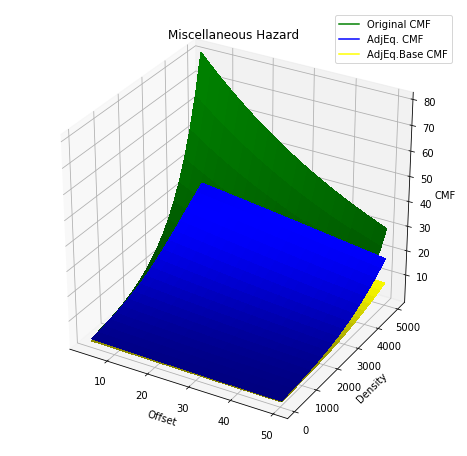

In [7]:
#%matplotlib notebook
Feature = 'Misc'
Setting = ('Rural','Undivided')
Resolution = 20
offset  = np.linspace(4,50,Resolution)
density = np.linspace(50,5000,Resolution)
x = np.array([[i]*len(density) for i in offset])
y = np.array([density for i in offset])
Misc_Curr = np.array([[CMF_Fun(FeatureType=Feature,Settings=Setting,Values=pd.Series({'Offset':o,'Density':d})) for d in density] for o in offset])
Misc_Prop1 = np.array([[CMF_Fun_Prop(FeatureType=Feature,Settings=Setting,Values=pd.Series({'Offset':o,'Density':d})) for d in density] for o in offset])
Misc_Prop2 = np.array([[CMF_Fun_Prop(FeatureType=Feature,Base_DF=Base_Cond_Prop,Settings=Setting,Values=pd.Series({'Offset':o,'Density':d})) for d in density] for o in offset])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
proxy_plot_l = []
ax.plot_surface(x, y, Misc_Curr,rstride=1, cstride=1,  linewidth=0, antialiased=False,color='green')
proxy_plot_l.append(matplotlib.lines.Line2D([0],[0],color='green'))
ax.plot_surface(x, y, Misc_Prop1,rstride=1, cstride=1,  linewidth=0, antialiased=False,color='blue')
proxy_plot_l.append(matplotlib.lines.Line2D([0],[0],color='blue'))
ax.plot_surface(x, y, Misc_Prop2,rstride=1, cstride=1,  linewidth=0, antialiased=False,color='yellow')
proxy_plot_l.append(matplotlib.lines.Line2D([0],[0],color='yellow'))
plt.xlabel('Offset')
plt.ylabel('Density')
plt.title('Miscellaneous Hazard')
plt.gca().set_zlabel('CMF')
plt.legend(proxy_plot_l, ['Original CMF','AdjEq. CMF','AdjEq.Base CMF'], numpoints = 1)
plt.savefig('Misc_Comp.png',dpi=1200,transparent=True)
plt.show()

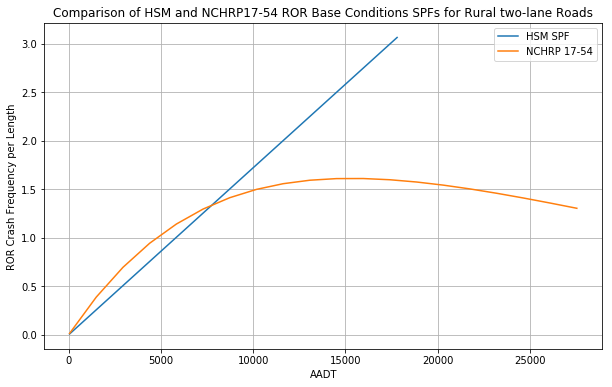

In [8]:
HSM_SPF = lambda row:row.AADT*365*10**(-6)*np.exp(-0.312)*row.Length
ROR_SPF = lambda row:np.exp(-6.535e-5*row.AADT-9.441e-3*row.PT-14.75)*row.AADT*365*row.Length
PT = 0.1
Length = 1
X1 = np.linspace(50,17800,Resolution)
X2 = np.linspace(50,27540,Resolution)
ratio = (54.7+3.7+3.4+3.8*.7)/100.0
Y1 = [ratio*HSM_SPF(pd.Series({'AADT':a,'Length':Length})) for a in X1]
Y2 = [2*ROR_SPF(pd.Series({'AADT':a,'Length':Length,'PT':PT})) for a in X2]
plt.figure(figsize=(10,6))
plt.plot(X1,Y1,label='HSM SPF')
plt.plot(X2,Y2,label='NCHRP 17-54')
plt.grid();plt.legend()
plt.xlabel('AADT')
plt.ylabel('ROR Crash Frequency per Length')
plt.title('Comparison of HSM and NCHRP17-54 ROR Base Conditions SPFs for Rural two-lane Roads')
plt.savefig('SPF_Comp.png',dpi=1200,transparent=True)
plt.show()

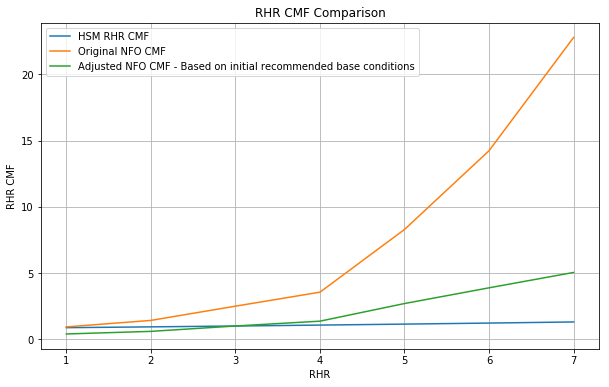

In [9]:
Feature = 'NFO'
Setting = ('Rural','Undivided')
RHR_CMF = lambda RHR:np.exp(-0.6869+0.0668*RHR)/np.exp(-0.4865)
X1 = np.linspace(1,7)
#RHR = [NFO Offset, NFO Density]
RHR_Dict = {1:[40,30],2:[25,30],3:[10,60],4:[7.5,120],5:[7.5,300],6:[5,400],7:[5,500]}

Y1 = [RHR_CMF(rhr) for rhr in X1]
Y2 = [CMF_Fun(FeatureType=Feature,Settings=Setting,Values=pd.Series({'Offset':RHR_Dict[l][0],'Density':RHR_Dict[l][1]})) for l in RHR_Dict]
Y3 = [CMF_Fun_Prop(Base_DF=Base_Cond_Prop,FeatureType=Feature,Settings=Setting,Values=pd.Series({'Offset':RHR_Dict[l][0],'Density':RHR_Dict[l][1]})) for l in RHR_Dict]

plt.figure(figsize=(10,6))
plt.plot(X1,Y1,label='HSM RHR CMF')
plt.plot(RHR_Dict.keys(),Y2,label='Original NFO CMF')
plt.plot(RHR_Dict.keys(),Y3,label='Adjusted NFO CMF - Based on initial recommended base conditions')
plt.grid();plt.legend()
plt.xlabel('RHR')
plt.ylabel('RHR CMF')
plt.title('RHR CMF Comparison')
plt.savefig('RHR_CMF.png',dpi=1200,transparent=True)
plt.show()